### Objectives:
##### Primary Objective: 
Identify specific furnaces that are underperforming in terms of energy efficiency to target for improvement initiatives. This could lead to maintenance, or process optimisation.
##### Analytical Objectives:
1. Rank furnaces by energy efficiency: Clearly determine which furnaces exhibit the highest kWh/tonne values (Worst Performer).
2. Investigate potential correlations: Explore if kWh/tonne correlates with Tonnes/hour or kWh/hour to understand contributing factors to poor performance. For example, is a furnace consuming more energy per tonne because it's running slower, or because it's inherently less efficient?
3. Quantify the performance gap: Determine the difference in kWh/tonne between the worst and best-performing furnaces.
##### Key Metrics and Their Relevance:
1. kWh (energy consumed): Total energy used. This is a primary cost driver.
2. Tonnes (output): Total material processed. This is a primary measure of productivity and revenue generation.
3. Cycle time (hours): Duration of one operational cycle. Important for understanding throughput and potential bottlenecks.
4. kWh per tonne (Energy Efficiency Metric): This is our primary metric of interest. It directly measures how much energy is required to produce one tonne of output.
* Relevance: A higher kWh/tonne indicates lower energy efficiency and higher energy cost per unit of production. This is the direct measure for identifying our "worst performing" furnace from an energy perspective.
5. Tonnes per hour (Productivity Metric): Measures the rate of production.
6. kWh per hour (Energy Consumption Rate Metric): Measures the rate at which energy is consumed.
* Relevance: This helps us understand the intensity of energy use. A high kWh/hour doesn't necessarily mean poor energy efficiency if productivity (Tonnes/hour) is also very high. However, if kWh/hour is high while Tonnes/hour is low, it points to significant inefficiency.
##### What "Poor Performance" Means in Measurable Terms:
For this analysis, "poor performance" is primarily defined by:
* High kWh/tonne: A furnace is considered a poor performer if its kWh/tonne value is significantly higher than the average kWh/tonne across all furnaces, or if it consistently ranks among the highest values. We might define a threshold, e.g., "any furnace with kWh/tonne greater than the 75th percentile" or "the top 2 furnaces with the highest kWh/tonne."
##### Expected Insights from the Analysis:
1. Identification of the Worst-Performing Furnace(s): A clear ranking of furnaces by kWh/tonne, pinpointing the primary target(s) for improvement.
2. Quantification of the Energy Efficiency Gap: Understanding how much more energy the worst performer(s) use per tonne compared to the best performer(s).
3. Potential Root Causes (Hypotheses): Insights might suggest why a furnace is performing poorly. For example:
* Is high kWh/tonne due to low Tonnes/hour (e.g., slow cycle times, frequent downtime)?
* Is it due to inherently high kWh/hour even at normal productivity (e.g., older equipment, insulation issues, inefficient heating elements)?
* Are there specific operating conditions (e.g., higher temperatures, different material batches) that lead to worse efficiency for certain furnaces?
4. Foundation for Recommendations: The analysis will provide the evidence needed to recommend specific actions, such as:
* Targeted maintenance for inefficient furnaces.
* Process optimisation (e.g., adjusting cycle times, pre-heating procedures).

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Load the dataset

In [2]:
file_path = "U:\Desktop\Data Source\STEEL TREATMENT.xlsx"
df_raw = pd.read_excel(file_path, na_values=['#DIV/0!', 'NaN', ' '])
df = df_raw.copy()
print("Dataset loaded successfully.")

Dataset loaded successfully.


### Data Preparation and Cleaning

##### Missing Values and Downtime Detection

In [3]:
missing_counts = df.isnull().sum()
missing_columns = missing_counts[missing_counts > 0].sort_values(ascending=False)

print("\nMissing/Invalid Value Counts (Downtime/Errors per Metric):")
print(missing_columns.to_string())


Missing/Invalid Value Counts (Downtime/Errors per Metric):
INGOT_FURNACE_KWH_TONNE        232
INGOT_FURNACE_TONNES_HOUR      225
INGOT_FURNACE_KWH_HOUR         225
NO5_FURNACE_KWH_TONNE          208
NO5_FURNACE_TONNES_HOUR        207
NO5_FURNACE_KWH_HOUR           207
NO2_FURNACE_KWH_TONNE          143
NO2_FURNACE_KWH_HOUR           142
NO2_FURNACE_TONNES_HOUR        142
NO4_FURNACE_KWH_TONNE          115
NO4_FURNACE_TONNES_HOUR        114
NO4_FURNACE_KWH_HOUR           114
NO1_FURNACE_KWH_TONNE           94
NO1_FURNACE_TONNES_HOUR         94
NO1_FURNACE_KWH_HOUR            94
LIFTOFF_FURNACE_TONNES_HOUR     87
LIFTOFF_FURNACE_KWH_TONNE       87
LIFTOFF_FURNACE_KWH_HOUR        87
NO3_FURNACE_TONNES_HOUR         76
NO3_FURNACE_KWH_HOUR            76
NO3_FURNACE_KWH_TONNE           76


##### Reshape Data for Grouped Analysis (Melting)

In [4]:
furnaces = ['NO1', 'NO2', 'NO3', 'NO4', 'NO5', 'LIFTOFF', 'INGOT']
metric_map = {
    'KWH': 'kWh',
    'TONNES': 'Tonnes',
    'CYCLETIME_HOURS': 'Cycle_Time_Hours',
    'KWH_TONNE': 'kWh_per_Tonne',
    'TONNES_HOUR': 'Tonnes_per_Hour',
    'KWH_HOUR': 'kWh_per_Hour'
}
df_long_list = []

# Iterate through furnaces and stack the data
for furnace in furnaces:
# Create a mapping from wide column names to generic metric names
    cols_map = {
        f'{furnace}_FURNACE_{source_suffix}': target_name 
        for source_suffix, target_name in metric_map.items()
    }
# Select and rename columns, ensuring 'DATE' is always included
    keys_to_select = ['DATE'] + list(cols_map.keys())
    df_temp = df[keys_to_select].rename(columns=cols_map).copy()
    
    if not df_temp.empty:
        df_temp['Furnace_ID'] = furnace
        
# Create Furnace_Active flag (1 = Operating, 0 = Downtime)
# Downtime is defined by key metrics (kWh or Tonnes) being NaN or zero.
# We check if 'kWh' is NOT NaN AND is greater than 0.
        is_active = (df_temp['kWh'].notna()) & (df_temp['kWh'] > 0)
        df_temp['Furnace_Active'] = np.where(is_active, 1, 0)
        
        df_long_list.append(df_temp)

df_final_model = pd.concat(df_long_list, ignore_index=True)

print(f"Final Model Data Shape (Long Format): {len(df_final_model)} rows")

# Consistency Check (Optional but Recommended)

print("\n                     Consistency Check (Calculated vs. Reported) ")
# Check if the calculated kWh/Tonne is close to the reported value for active cycles
df_active = df_final_model[df_final_model['Furnace_Active'] == 1].copy()

# Calculate the difference between the reported and calculated values
df_active['Calculated_kWh_per_Tonne'] = df_active['kWh'] / df_active['Tonnes']
df_active['Consistency_Error'] = abs(df_active['Calculated_kWh_per_Tonne'] - df_active['kWh_per_Tonne'])

# Print max error (should be very small, indicating consistency)
max_error = df_active['Consistency_Error'].max()
print(f"Maximum absolute error between reported and calculated kWh_per_Tonne: {max_error:.4f}")
if max_error > 0.1:
    print("Warning: There may be minor inconsistencies in the source data calculations.")
else:
    print("Data is highly consistent.")


# Preview of the cleaned and transformed dataset (10 rows).
print("\n                     Cleaned and Transformed Data Preview (10 Rows) ")
# Display the final modeling dataset, sorted by date and furnace
df_preview = df_final_model.sort_values(by=['DATE', 'Furnace_ID'])
print(df_preview[['DATE', 'Furnace_ID', 'Furnace_Active', 'kWh', 'Tonnes', 'kWh_per_Tonne']].head(10).to_string())

# Summarise the number of downtime occurrences per furnace.
downtime_summary = df_final_model.groupby('Furnace_ID')['Furnace_Active'].value_counts().unstack(fill_value=0)
downtime_summary['Total Weeks'] = downtime_summary.sum(axis=1)

# Ensure '0' (Downtime) and '1' (Active) columns exist for clear display
downtime_summary = downtime_summary.rename(columns={0: 'Downtime Occurrences (0)', 1: 'Active Cycles (1)'})
downtime_summary = downtime_summary[['Total Weeks', 'Active Cycles (1)', 'Downtime Occurrences (0)']]

print("\n                     Downtime Occurrences per Furnace ")
print(downtime_summary.to_string())

Final Model Data Shape (Long Format): 2849 rows

                     Consistency Check (Calculated vs. Reported) 
Maximum absolute error between reported and calculated kWh_per_Tonne: 109.2000

                     Cleaned and Transformed Data Preview (10 Rows) 
           DATE Furnace_ID  Furnace_Active            kWh   Tonnes  kWh_per_Tonne
2442 2018-01-06      INGOT               0       0.000000    0.000            NaN
2035 2018-01-06    LIFTOFF               1   95644.861111  264.087     362.171789
0    2018-01-06        NO1               1   94328.194444   83.600    1128.327685
407  2018-01-06        NO2               1   98771.944444  130.500     756.873138
814  2018-01-06        NO3               1  113013.888889   94.700    1193.388478
1221 2018-01-06        NO4               1  119114.444444  136.040     875.583979
1628 2018-01-06        NO5               1  121550.277778  132.000     920.835438
2443 2018-01-13      INGOT               0       0.000000    0.000            Na

### Exploratory Data Analysis (EDA)

##### Distribution Analysis

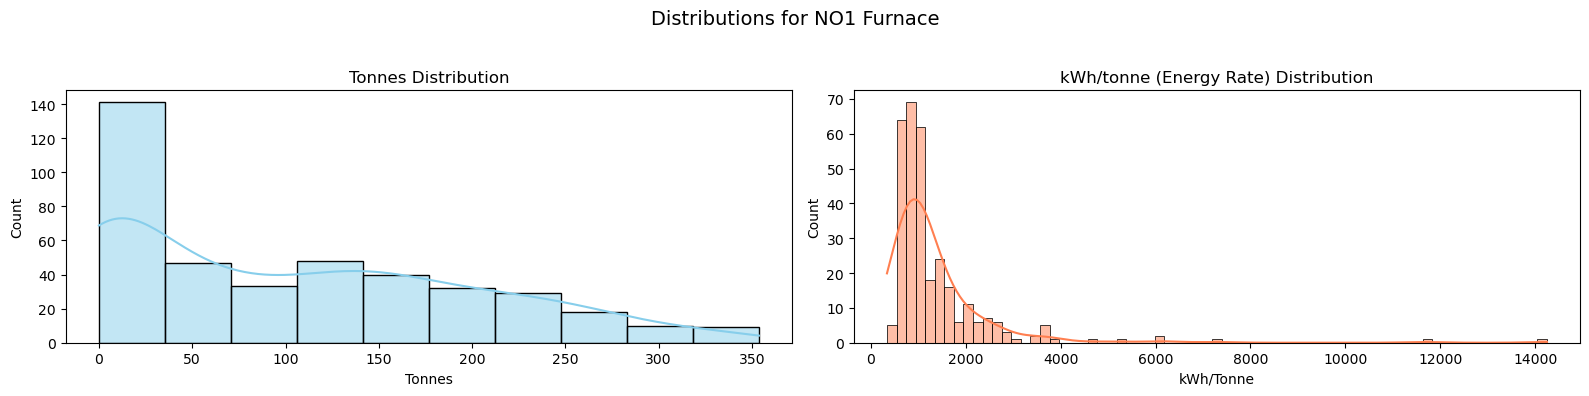

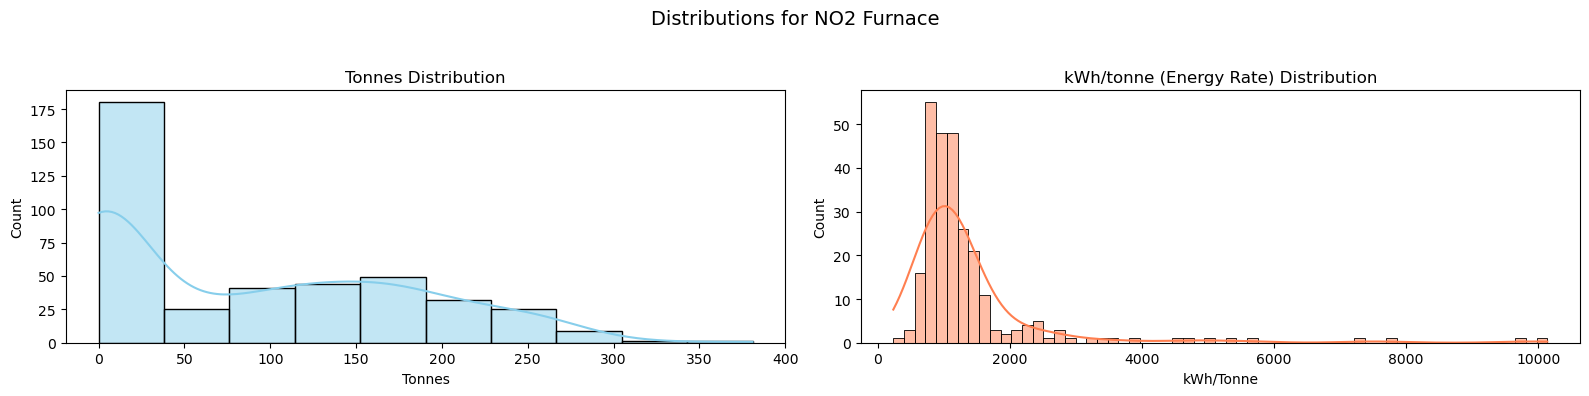

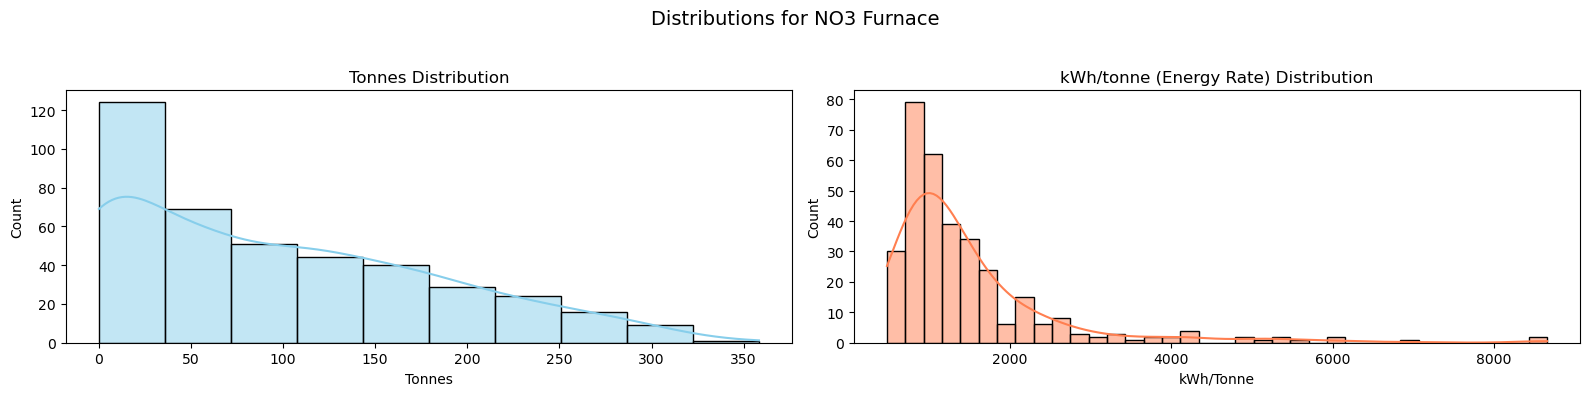

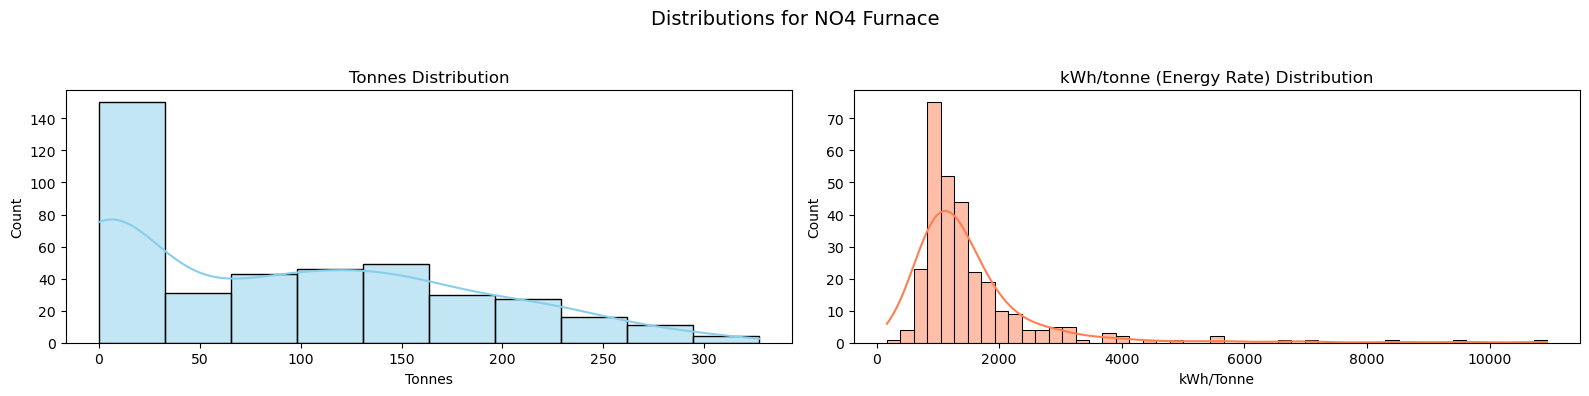

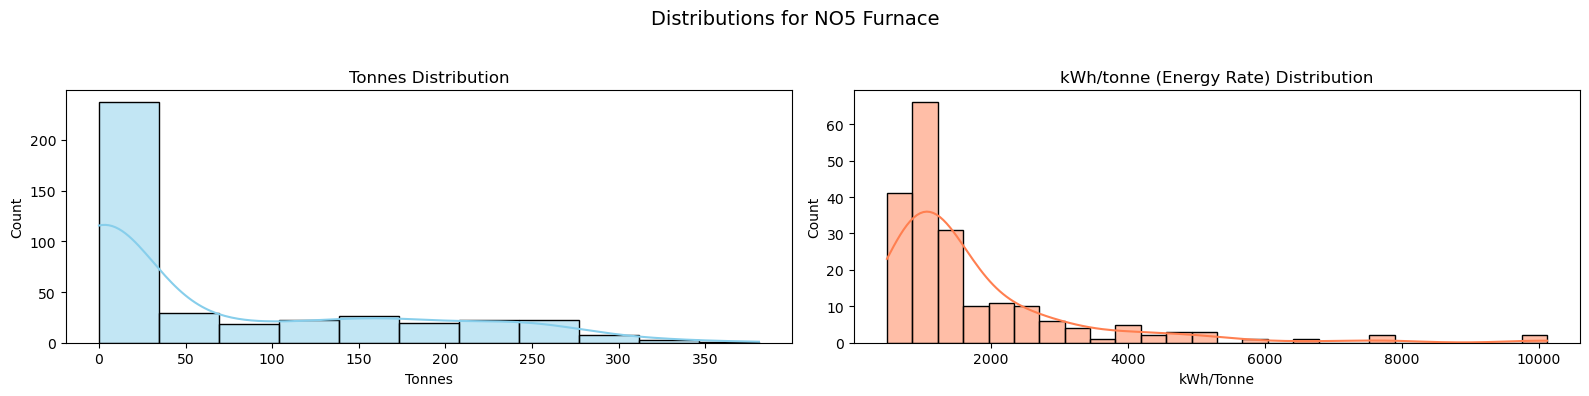

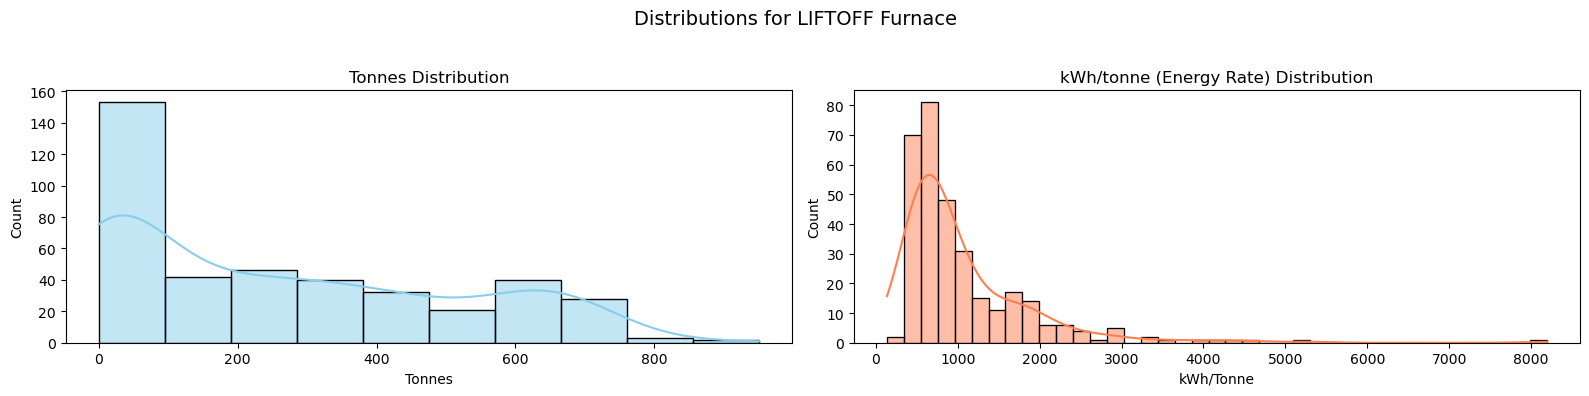

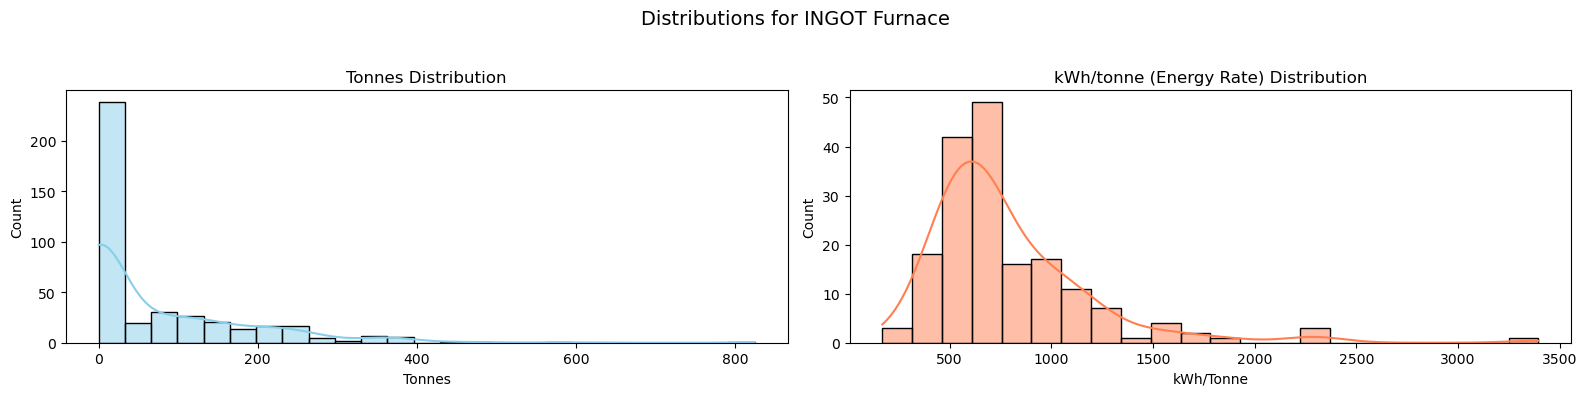


The distribution plots help visualise the typical operating ranges and variability in production volume (Tonnes) and energy efficiency (kWh/Tonne) for each furnace, highlighting potential outliers or consistent patterns. Some furnaces might show a bimodal distribution if they handle different product types or operating modes.


In [5]:
for f in furnaces:
    tonnes_col = f + '_FURNACE_TONNES'
    kwh_tonne_col = f + '_FURNACE_KWH_TONNE'
    
# Check if at least one column exists before creating the figure
    if tonnes_col in df.columns or kwh_tonne_col in df.columns:
        
# Create a figure with a 1-row, 2-column subplot grid
        fig, axes = plt.subplots(1, 2, figsize=(16, 4))
        fig.suptitle(f'Distributions for {f} Furnace', fontsize=14)

        # Plot 1: Tonnes Distribution
        if tonnes_col in df.columns:
            sns.histplot(df[tonnes_col].dropna(), kde=True, ax=axes[0], color='skyblue')
            axes[0].set_title('Tonnes Distribution')
            axes[0].set_xlabel('Tonnes')
        else:
            # Hide subplot if the data is missing
            fig.delaxes(axes[0])
        
        # Plot 2: kWh/tonne Distribution
        if kwh_tonne_col in df.columns:
            sns.histplot(df[kwh_tonne_col].dropna(), kde=True, ax=axes[1], color='coral')
            axes[1].set_title('kWh/tonne (Energy Rate) Distribution')
            axes[1].set_xlabel('kWh/Tonne')
        else:
            # Hide subplot if the data is missing
            fig.delaxes(axes[1])

        plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent suptitle overlap
        plt.show()
print("\nThe distribution plots help visualise the typical operating ranges and variability in production volume (Tonnes) and energy efficiency (kWh/Tonne) for each furnace, highlighting potential outliers or consistent patterns. Some furnaces might show a bimodal distribution if they handle different product types or operating modes.")

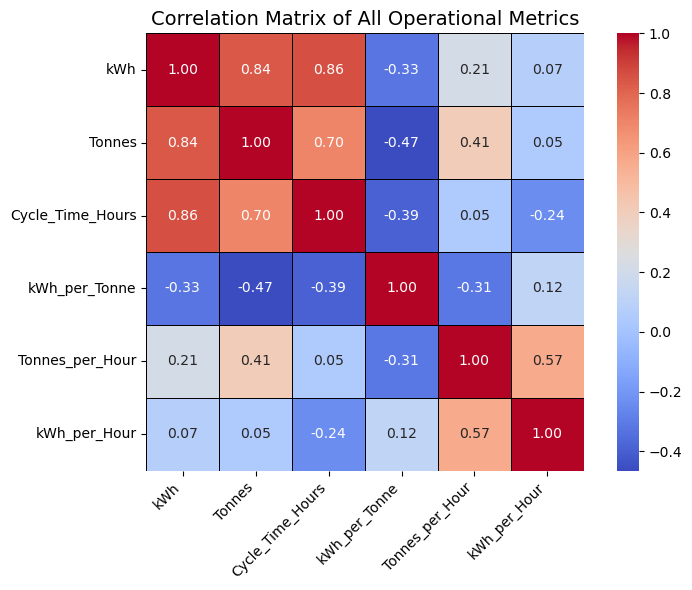


Variables influencing kWh/tonne (from Correlation Matrix):
kWh_per_Tonne       1.000000
kWh_per_Hour        0.123714
Tonnes_per_Hour    -0.312890
kWh                -0.326032
Cycle_Time_Hours   -0.391717
Tonnes             -0.465217


In [6]:
all_metrics = ['kWh', 'Tonnes', 'Cycle_Time_Hours', 'kWh_per_Tonne', 
               'Tonnes_per_Hour', 'kWh_per_Hour']

# Correlation Matrix across all metrics (Active Cycles)
correlation_matrix = df_active[all_metrics].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=.5, linecolor='black', square=True)
plt.title('Correlation Matrix of All Operational Metrics', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Identify influence on kWh/tonne
print("\nVariables influencing kWh/tonne (from Correlation Matrix):")
print(correlation_matrix['kWh_per_Tonne'].sort_values(ascending=False).to_string())

#### Insights on Energy Efficiency (kWh/tonne) from the Matrix
The correlations indicate that the process becomes more energy efficient (i.e., kWh/tonne decreases) as the following variables increase:
##### 1. Tonnes **(-0.465) (Moderate)** : Tonnes is the Strongest Driver of Efficiency. This is the strongest correlation. Producing a higher total volume of output (Tonnes) is most associated with an improvement in energy efficiency (lower kWh/tonne).
##### 2. Cycle_Time_Hours **(-0.391) (Moderate)**: Longer Runs are More Efficient. Longer total operational times are associated with better efficiency. This could imply that short cycles contain inefficient periods **(like ramp-up/ramp-down)** that are minimised during long, steady-state operations.
##### 3. kWh **(-0.326) (Weak-Moderate)**: Higher total energy consumption is weakly associated with an efficiency improvement, likely because total energy is highly correlated with both Tonnes and Cycle_Time_Hours.
##### 4. Tonnes_per_Hour **(-0.312) (Weak-Moderate)**: A faster production rate is also weakly associated with better efficiency.

### Feature Engineering

In [7]:
# Calculate overall means for ratio features
mean_kwh_tonne_overall = df_active['kWh_per_Tonne'].mean()
mean_tonnes_hour_overall = df_active['Tonnes_per_Hour'].mean()

# Energy_Efficiency_Index (Normalised kWh_per_Tonne)
# Use MinMaxScaler to scale kWh_per_Tonne between 0 and 1
# Note: Since high kWh/tonne is bad, a high index (near 1) means LOW efficiency.
scaler = MinMaxScaler()
df_active['Energy_Efficiency_Index'] = scaler.fit_transform(
    df_active[['kWh_per_Tonne']]
)

# Relative_Performance (Efficiency Ratio)
df_active['Relative_Performance'] = (
    df_active['kWh_per_Tonne'] / mean_kwh_tonne_overall
)

# Throughput_Ratio (Throughput Ratio)
df_active['Throughput_Ratio'] = (
    df_active['Tonnes_per_Hour'] / mean_tonnes_hour_overall
)

# Cycle_Efficiency (Tonnes / Cycle_Time_Hours)
# This is mathematically equivalent to Tonnes_per_Hour, but we'll include it for completeness
# We use .where() to avoid division by zero errors, although df_active should not have this.
df_active['Cycle_Efficiency'] = np.where(
    df_active['Cycle_Time_Hours'] != 0, 
    df_active['Tonnes'] / df_active['Cycle_Time_Hours'], 
    np.nan
)
# Note: After calculation, Cycle_Efficiency should be identical to Tonnes_per_Hour
# Energy_Load (kWh / Cycle_Time_Hours)
# This is mathematically equivalent to kWh_per_Hour.
df_active['Energy_Load'] = np.where(
    df_active['Cycle_Time_Hours'] != 0, 
    df_active['kWh'] / df_active['Cycle_Time_Hours'], 
    np.nan
)

# Temporal Features (Year and Month)
df_active['Year'] = df_active['DATE'].dt.year
df_active['Month'] = df_active['DATE'].dt.month

# Downtime_Frequency (Furnace-level aggregated feature)
# Calculate Downtime Frequency from the full dataset (df_final_model)
downtime_counts = df_final_model.groupby('Furnace_ID')['Furnace_Active'].agg(
    total_records='count', 
    active_records='sum'
).reset_index()

downtime_counts['Downtime_Frequency'] = (
    1 - (downtime_counts['active_records'] / downtime_counts['total_records'])
)
df_active = pd.merge(
    df_active, 
    downtime_counts[['Furnace_ID', 'Downtime_Frequency']], 
    on='Furnace_ID', 
    how='left'
)

print("Preview of Engineered Features (10 rows):")
preview_cols = ['DATE', 'Furnace_ID', 'kWh_per_Tonne', 'Energy_Efficiency_Index', 
                'Relative_Performance', 'Throughput_Ratio', 'Downtime_Frequency', 
                'Year', 'Energy_Load']
print(df_active[preview_cols].head(10).to_string())

Preview of Engineered Features (10 rows):
        DATE Furnace_ID  kWh_per_Tonne  Energy_Efficiency_Index  Relative_Performance  Throughput_Ratio  Downtime_Frequency  Year  Energy_Load
0 2018-01-06        NO1    1128.327685                 0.070422              0.831840          0.639418             0.22113  2018  1328.566119
1 2018-01-13        NO1     965.775550                 0.058904              0.712001          0.942067             0.22113  2018  1675.410628
2 2018-01-20        NO1     591.602484                 0.032390              0.436149          1.587495             0.22113  2018  1729.439853
3 2018-01-27        NO1     822.940931                 0.048783              0.606699          0.990184             0.22113  2018  1500.539875
4 2018-02-03        NO1     932.453898                 0.056543              0.687435          1.004821             0.22113  2018  1725.358500
5 2018-02-10        NO1     821.730344                 0.048697              0.605806          0.966

### Modelling
###### Modelling: PREDICTIVE EFFICIENCY (Model Comparison)

In [8]:
# Define Target and Features (Already defined)
TARGET = 'kWh_per_Tonne'
FEATURES = [
    'Tonnes',
    'Cycle_Time_Hours',
    'Tonnes_per_Hour',
    'kWh_per_Hour',
    'Throughput_Ratio',
    'Downtime_Frequency',
    'Month'
]

# Drop rows with NaN values in the selected features/target (already done)
df_model = df_active.dropna(subset=FEATURES + [TARGET]).copy()

X = df_model[FEATURES]
y = df_model[TARGET]

# Split data (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardise features (Needed for Linear Regression)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)


# Function to train, predict, and evaluate a model
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Trains, predicts, and returns evaluation metrics."""
    # Determine which data set to use for training/testing based on model type
    if model_name == 'Linear Regression':
        X_train_data = X_train_scaled
        X_test_data = X_test_scaled
    else:
    # Use unscaled data for tree-based models (Random Forest, XGBoost)
        X_train_data = X_train
        X_test_data = X_test

    model.fit(X_train_data, y_train)
    y_pred = model.predict(X_test_data)

    # Calculate RMSE manually by taking the square root of MSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    metrics = {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R²': r2}
    return metrics, model, y_pred

# Initialize models for comparison
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost Regressor': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

results = []
trained_models = {}

# --- TRAIN AND EVALUATE ALL MODELS ---

for name, model in models.items():
    metrics, trained_model, _ = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    results.append(metrics)
    trained_models[name] = trained_model

df_results = pd.DataFrame(results).round(4)

print("\n--- Model Evaluation Summary ---")
print(df_results.to_string(index=False))

# --- DETERMINE THE BEST MODEL AND USE IT FOR PREDICTION ---

# Determine the best model (highest R-squared)
best_model_name = df_results.loc[df_results['R²'].idxmax(), 'Model']
best_model_r2 = df_results.loc[df_results['Model'] == best_model_name, 'R²'].iloc[0]
best_model = trained_models[best_model_name]

print(f"\nConclusion: The **{best_model_name}** is the best performing model (R²: {best_model_r2:.4f}).")


# --- ACCURATE PREDICTION FOR WORST PERFORMING FURNACE ---

print(f"\n --- Furnace Ranking by Predicted Inefficiency (Based on {best_model_name}) ---")

# Determine which data to pass to the best model (scaled or unscaled)
if best_model_name == 'Linear Regression':
    # If the best model is LR, use the entire scaled dataset X
    X_predict = scaler_X.transform(X)
else:
    # If the best model is a tree model, use the entire unscaled dataset X
    X_predict = X

# Use the best model for prediction on the entire dataset
df_model.loc[:, 'Predicted_kWh_per_Tonne'] = best_model.predict(X_predict)

# Calculate the average predicted efficiency per furnace
# The worst performing furnace is the one with the highest average Predicted_kWh_per_Tonne
furnace_ranking = df_model.groupby('Furnace_ID')['Predicted_kWh_per_Tonne'].mean().sort_values(ascending=False).reset_index()
furnace_ranking['Rank'] = furnace_ranking.index + 1

# Add actual average kWh/Tonne to the ranking for comparison
#actual_avg_kwh = df_model.groupby('Furnace_ID')['kWh_per_Tonne'].mean().reset_index()
#furnace_ranking = pd.merge(furnace_ranking, actual_avg_kwh, on='Furnace_ID', suffixes=('_Predicted', '_Actual'))

# Extract the worst-performing furnace and best-performing furnace information
worst_furnace_id = furnace_ranking.iloc[0]['Furnace_ID']
worst_furnace_predicted_kwh_per_tonne = furnace_ranking.iloc[0]['Predicted_kWh_per_Tonne']

print("Furnace Efficiency Ranking (Rank 1 = Most Inefficient Predicted Performance):")
print(furnace_ranking.sort_values(by='Rank').to_string(index=False)) # Ensure sorting by Rank for display

print("\n --- Worst Performing Furnace Prediction Summary ---")
print(f"The best model, **{best_model_name}** (R²: {best_model_r2:.4f}), predicts that:")
print(f"The **worst performing furnace** is **{worst_furnace_id}**.")
print(f"Its average predicted energy inefficiency `kWh_per_Tonne` is **{worst_furnace_predicted_kwh_per_tonne:.4f}**.")

#print(f"\nThe **best performing furnace** is **{best_furnace_id}** with an average predicted `kWh_per_Tonne` of **{best_furnace_predicted_kwh_per_tonne:.4f}**.")

# Quantify the energy efficiency gap
#efficiency_gap_percentage = ((worst_furnace_predicted_kwh_per_tonne - best_furnace_predicted_kwh_per_tonne) / best_furnace_predicted_kwh_per_tonne) * 100
#print(f"\nInsight: There is an approximate **{efficiency_gap_percentage:.2f}% efficiency gap** in `kWh_per_Tonne` between the worst and best performing furnaces, based on predicted values. This quantifies the potential energy savings if the worst performer(s) could operate at the efficiency of the best.")

 #Quantification of the Energy Efficiency Gap
print("\n--- Energy Efficiency Gap Analysis ---")
# Get the furnace with the best (lowest) average kWh/Tonne
best_furnace_id = furnace_ranking.iloc[-1]['Furnace_ID']
best_furnace_predicted_kwh_per_tonne = furnace_ranking.iloc[-1]['Predicted_kWh_per_Tonne']

print(f"The **best performing furnace** is **{best_furnace_id}** (Avg Predicted kWh/Tonne: {best_furnace_predicted_kwh_per_tonne:.4f}).")
print(f"The **worst performing furnace** is **{worst_furnace_id}** (Avg Predicted kWh/Tonne: {worst_furnace_predicted_kwh_per_tonne:.4f}).")

efficiency_gap = worst_furnace_predicted_kwh_per_tonne - best_furnace_predicted_kwh_per_tonne
print(f"The energy inefficiency gap between the worst and best performing furnaces is: **{efficiency_gap:.4f} kWh/Tonne**.")
print(f"This means {worst_furnace_id} uses approximately **{efficiency_gap / best_furnace_predicted_kwh_per_tonne * 100:.2f}%** more energy per tonne than {best_furnace_id}.")

# Structured table for energy efficiency gap
gap_table_data = {
    'Metric': ['Worst Performing Furnace (Predicted kWh/Tonne)',
               'Best Performing Furnace (Predicted kWh/Tonne)',
               'Efficiency Gap (kWh/Tonne)',
               'Relative Gap (% of Efficiency Gap)'],
    'Value': [f"{worst_furnace_predicted_kwh_per_tonne:.4f} ({worst_furnace_id})",
              f"{best_furnace_predicted_kwh_per_tonne:.4f} ({best_furnace_id})",
              f"{efficiency_gap:.4f}",
              f"{efficiency_gap / best_furnace_predicted_kwh_per_tonne * 100:.2f}%"]
}
df_gap_table = pd.DataFrame(gap_table_data)
print("\nEnergy Efficiency Gap")
print(df_gap_table.to_string(index=False))



--- Model Evaluation Summary ---
                  Model      RMSE      MAE      R²
      Linear Regression 1706.1960 486.8294 -1.6696
Random Forest Regressor  205.4819  63.7183  0.9613
      XGBoost Regressor  211.2787  71.3021  0.9591

Conclusion: The **Random Forest Regressor** is the best performing model (R²: 0.9613).

 --- Furnace Ranking by Predicted Inefficiency (Based on Random Forest Regressor) ---
Furnace Efficiency Ranking (Rank 1 = Most Inefficient Predicted Performance):
Furnace_ID  Predicted_kWh_per_Tonne  Rank
       NO5              1742.210430     1
       NO4              1548.561603     2
       NO3              1502.070022     3
       NO2              1371.556057     4
       NO1              1364.244810     5
   LIFTOFF              1066.570283     6
     INGOT               800.470665     7

 --- Worst Performing Furnace Prediction Summary ---
The best model, **Random Forest Regressor** (R²: 0.9613), predicts that:
The **worst performing furnace** is **NO5**.
I

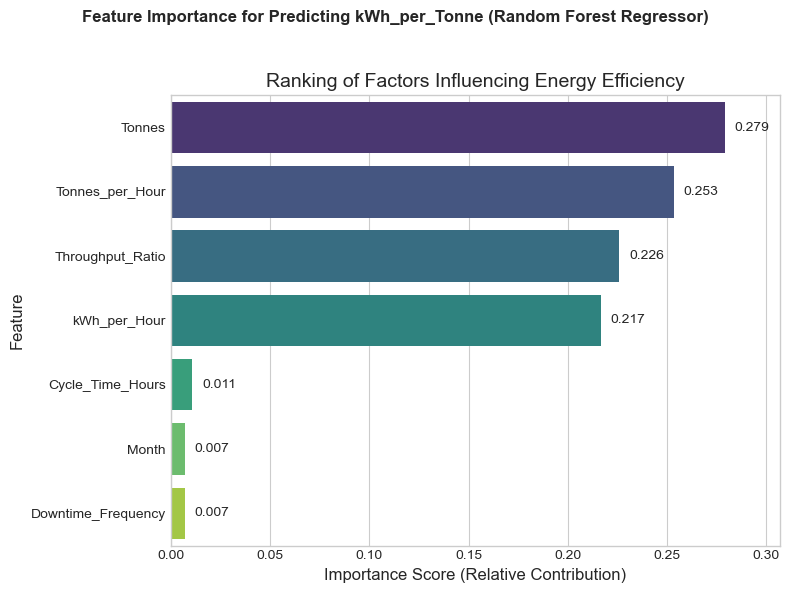


The Feature Importance plot for the Random Forest Regressor model highlights the most significant drivers of `kWh_per_Tonne`. Features with higher scores have a greater impact on predicted energy efficiency, guiding where to focus improvement efforts.


In [9]:
# Check if the best model supports feature_importances_
if hasattr(best_model, 'feature_importances_'):
    # Feature Importance
    rf_importance = pd.Series(best_model.feature_importances_, index=FEATURES).sort_values(ascending=False)

    # Use a style for better aesthetics
    plt.style.use('seaborn-v0_8-whitegrid') 
    
    fig, ax = plt.subplots(figsize=(8, 6)) # Increased figure size
    
    plt.suptitle(
        f'Feature Importance for Predicting kWh_per_Tonne ({best_model_name})', 
        fontsize=12, 
        fontweight='bold'
    )

    # Plot Importance with corrected syntax and better aesthetics
    sns.barplot(
        x=rf_importance.values,
        y=rf_importance.index,
        ax=ax,
        hue=rf_importance.index,
        palette='viridis',       
        legend=False
    )
    
    # Customize axis labels and ticks
    ax.set_title(f'Ranking of Factors Influencing Energy Efficiency', fontsize=14)
    ax.set_xlabel('Importance Score (Relative Contribution)', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    
    # Add data labels (scores) to the bars
    for i, score in enumerate(rf_importance.values):
        ax.text(score + 0.005, i, f'{score:.3f}', va='center', fontsize=10)
        
    # Set the x-axis limit slightly higher than the max score
    ax.set_xlim(0, rf_importance.values.max() * 1.1)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    plt.style.use('default') 
print(f"\nThe Feature Importance plot for the {best_model_name} model highlights the most significant drivers of `kWh_per_Tonne`. Features with higher scores have a greater impact on predicted energy efficiency, guiding where to focus improvement efforts.")

### Evaluation and Insights

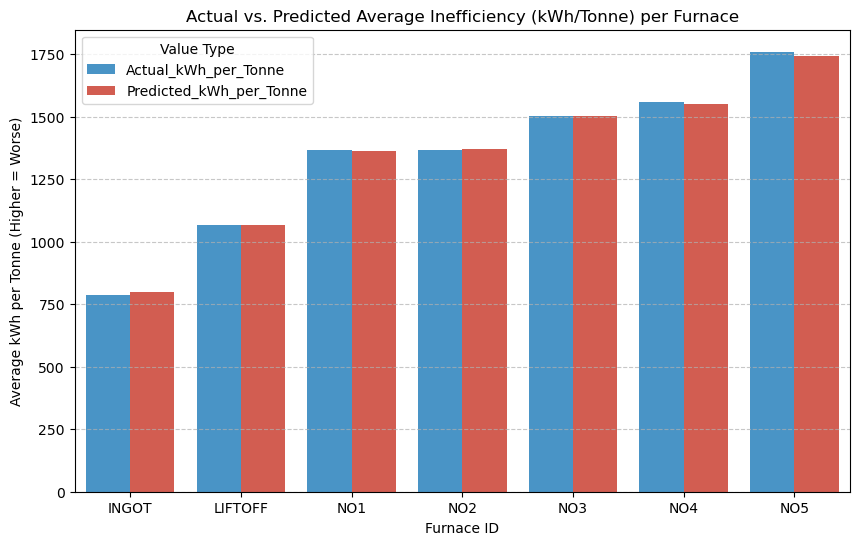


This bar chart visually confirms the model's ability to predict average furnace inefficiency, showing how closely predicted values align with actual performance. It also visually reinforces the ranking of furnaces, confirming which ones are consistently more inefficient.


In [10]:
#Compare Actual vs Predicted kWh/tonne per furnace (bar chart)
# Group data to calculate the mean actual and predicted kWh/Tonne per furnace
avg_performance_df = df_model.groupby('Furnace_ID').agg(
    Actual_kWh_per_Tonne=('kWh_per_Tonne', 'mean'),
    Predicted_kWh_per_Tonne=('Predicted_kWh_per_Tonne', 'mean')
).reset_index()

# Melt the DataFrame for plotting (long format required by seaborn barplot)
performance_melted = avg_performance_df.melt(
    id_vars='Furnace_ID', 
    var_name='Type', 
    value_name='Avg_kWh_per_Tonne'
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=performance_melted, 
    x='Furnace_ID', 
    y='Avg_kWh_per_Tonne', 
    hue='Type', 
    palette=['#3498db', '#e74c3c']
)
plt.title('Actual vs. Predicted Average Inefficiency (kWh/Tonne) per Furnace')
plt.xlabel('Furnace ID')
plt.ylabel('Average kWh per Tonne (Higher = Worse)')
plt.legend(title='Value Type')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()
print("\nThis bar chart visually confirms the model's ability to predict average furnace inefficiency, showing how closely predicted values align with actual performance. It also visually reinforces the ranking of furnaces, confirming which ones are consistently more inefficient.")

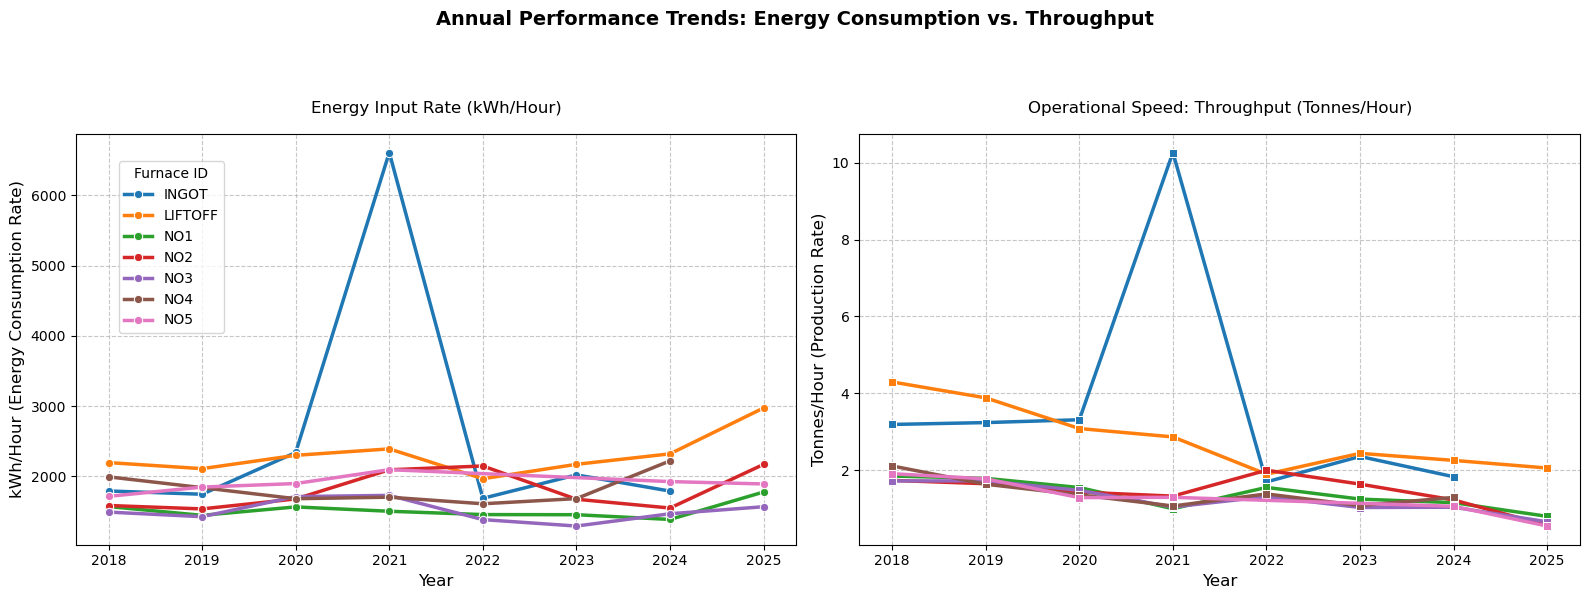


By comparing the trends of 'Energy Input Rate (kWh/Hour)' and 'Throughput (Tonnes/Hour)', we can hypothesise root causes for inefficiency. For instance, a furnace showing increasing kWh/Hour but flat or decreasing Tonnes/Hour over time is becoming less efficient due to higher energy losses or equipment degradation, while one with consistently low Tonnes/Hour indicates process bottlenecks or underutilisation.


In [11]:
# Group data by Furnace ID and Year, calculating the mean of the two key rate metrics
df_rate_analysis = df_active.groupby(['Furnace_ID', 'Year']).agg(
    Avg_kWh_per_Hour=('kWh_per_Hour', 'mean'),
    Avg_Tonnes_per_Hour=('Tonnes_per_Hour', 'mean')
).reset_index()

# Set up the figure for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # Focused size for clarity
plt.suptitle('Annual Performance Trends: Energy Consumption vs. Throughput', 
             fontsize=14, fontweight='bold', y=1.02)

# Define a distinct palette for the six furnace lines
furnace_palette = sns.color_palette("tab10", n_colors=len(df_rate_analysis['Furnace_ID'].unique()))

# Plot 1: Energy Input Rate (kWh/Hour) - Indicator of Equipment Health/Losses
sns.lineplot(
    data=df_rate_analysis, 
    x='Year', 
    y='Avg_kWh_per_Hour', 
    hue='Furnace_ID', 
    marker='o', 
    palette=furnace_palette,
    ax=axes[0],
    linewidth=2.5 
)
axes[0].set_title('Energy Input Rate (kWh/Hour)', fontsize=12, pad=15)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('kWh/Hour (Energy Consumption Rate)', fontsize=12)
axes[0].legend(title='Furnace ID', bbox_to_anchor=(0.05, 0.95), loc='upper left', frameon=True, fancybox=True)
axes[0].grid(True, linestyle='--', alpha=0.7)
# Ensure x-axis shows only integer years
years = df_rate_analysis['Year'].unique()
axes[0].set_xticks(years)
axes[0].set_xticklabels([str(int(y)) for y in years])


# Plot 2: Throughput (Tonnes/Hour) - Indicator of Operational Speed/Process Control
sns.lineplot(
    data=df_rate_analysis, 
    x='Year', 
    y='Avg_Tonnes_per_Hour', 
    hue='Furnace_ID', 
    marker='s', 
    palette=furnace_palette, 
    ax=axes[1],
    linewidth=2.5 
)
axes[1].set_title('Operational Speed: Throughput (Tonnes/Hour)', fontsize=12, pad=15)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Tonnes/Hour (Production Rate)', fontsize=12)
# Remove duplicate legend from second plot, as it is already on the first
axes[1].legend().remove() 
axes[1].grid(True, linestyle='--', alpha=0.7)
# Ensure x-axis shows only integer years
axes[1].set_xticks(years)
axes[1].set_xticklabels([str(int(y)) for y in years])
axes[1].ticklabel_format(style='plain', axis='y') # Prevent scientific notation

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("\nBy comparing the trends of 'Energy Input Rate (kWh/Hour)' and 'Throughput (Tonnes/Hour)', we can hypothesise root causes for inefficiency. For instance, a furnace showing increasing kWh/Hour but flat or decreasing Tonnes/Hour over time is becoming less efficient due to higher energy losses or equipment degradation, while one with consistently low Tonnes/Hour indicates process bottlenecks or underutilisation.")

#### Insight from Annual Rate Analysis
##### 1. Operational Speed (Right Chart): This metric reflects **throughput and process control**. LIFTOFF is the clear leader in Tonnes/Hour, indicating superior operational speed. A decreasing trend, like seen in NO1, NO3 and NO5, suggests **operational drift** (slower handling/cycle times).
##### 2. The primary concern is any furnace where **kWh/Hour is rising (more energy used)** while **Tonnes/Hour is flat or falling (same or less output)**, as this represents a clear decline in **energy productivity**.

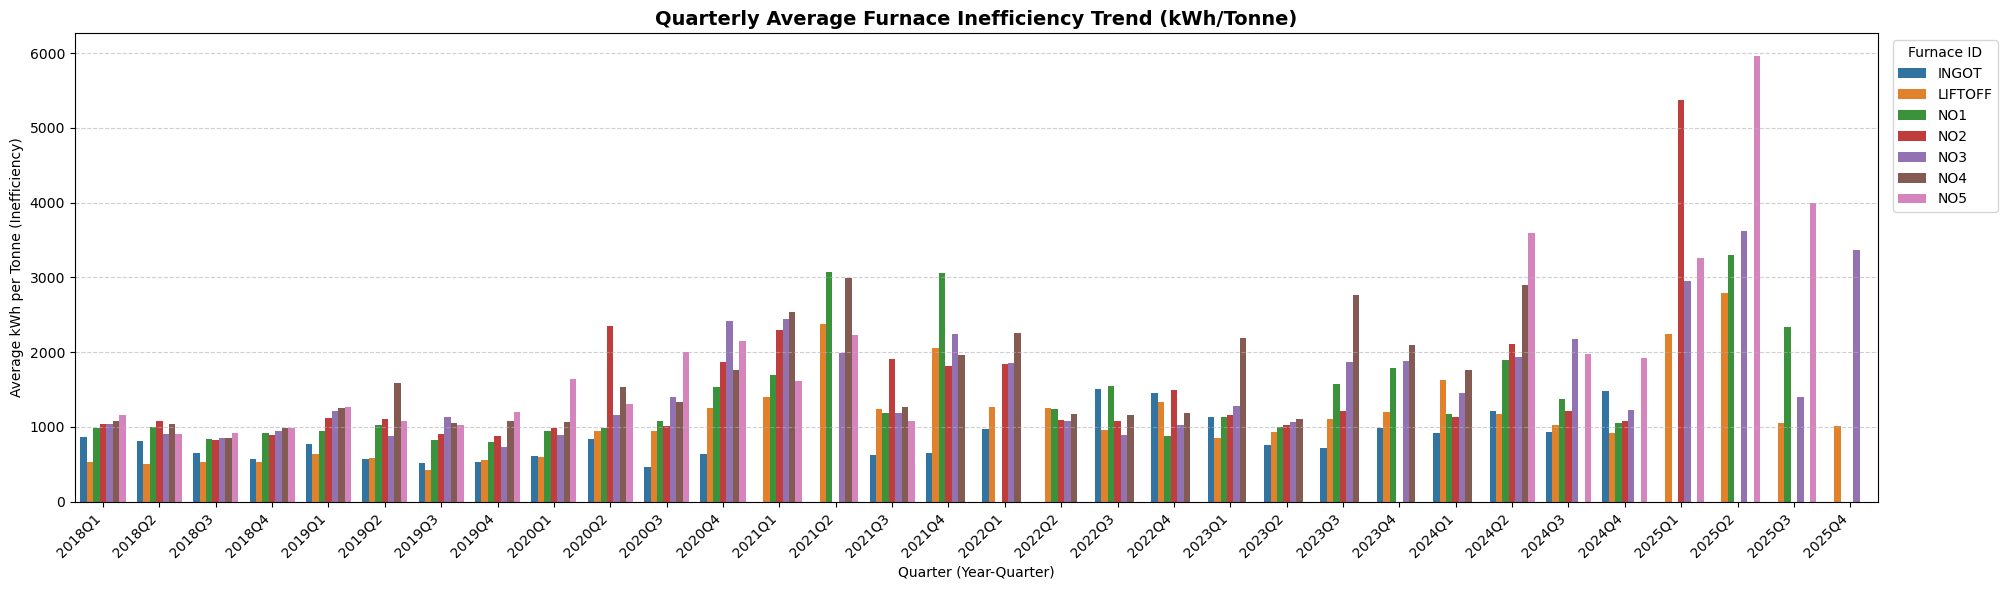


The quarterly bar plot provides a granular view of how each furnace's inefficiency (kWh/Tonne) evolves over time. This can help identify seasonal effects, impacts of maintenance, or long-term degradation specific to individual furnaces.


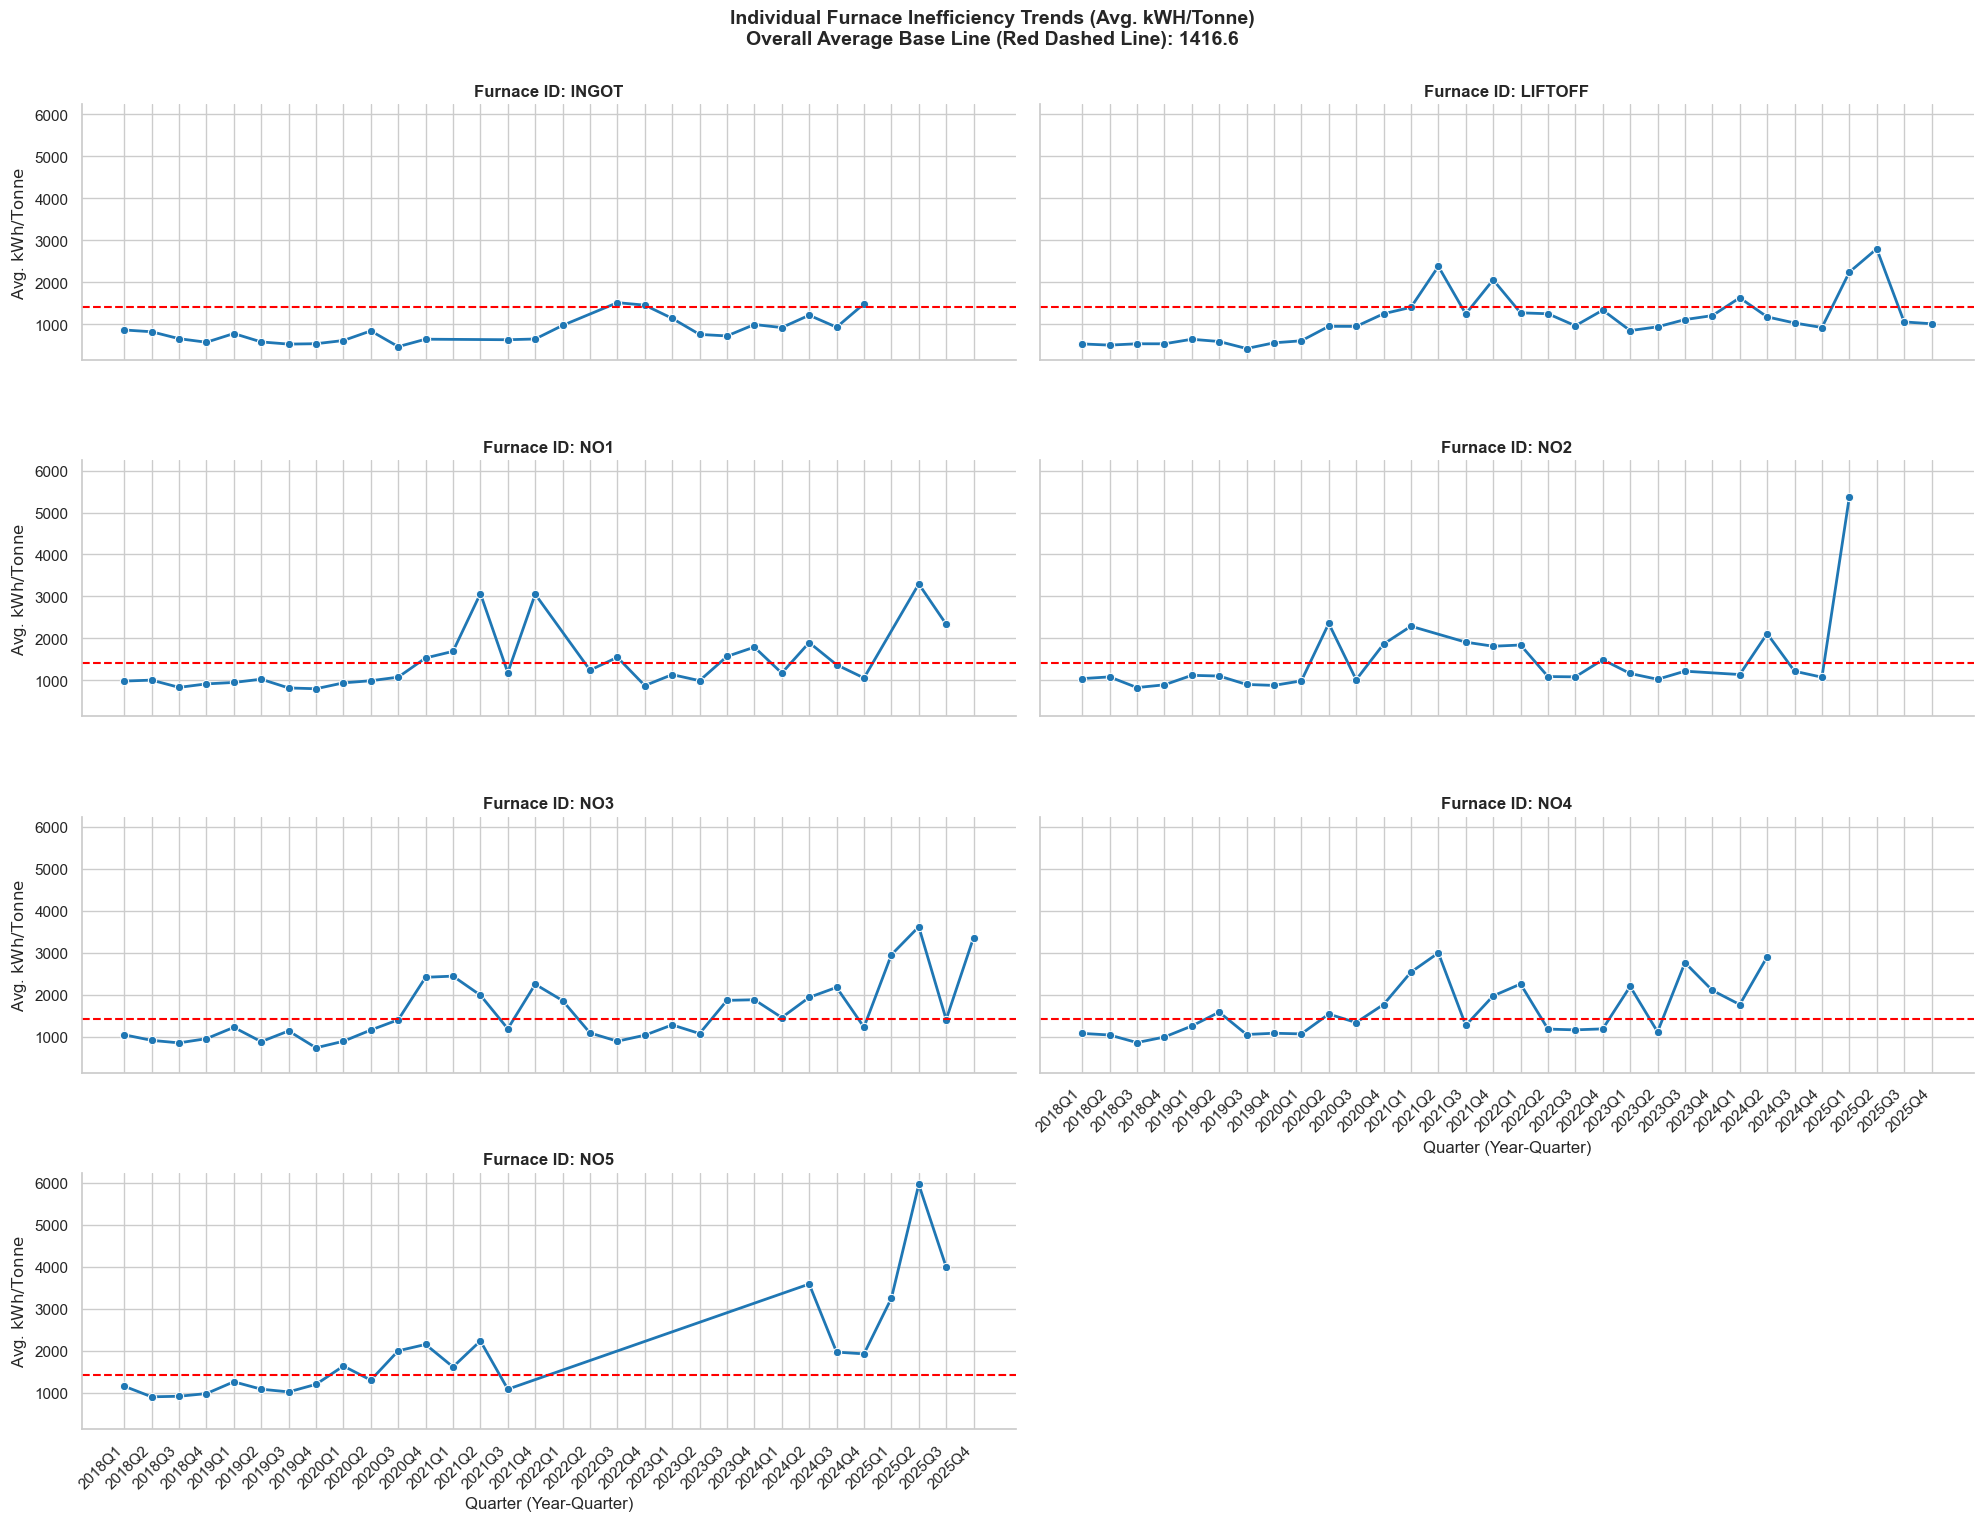

In [12]:
# Plot furnace efficiency trends over time (Quarterly Average Bar Plot)

# Calculate Quarter/Year for aggregation
df_model['Quarter_Period'] = df_model['DATE'].dt.to_period('Q')
# Group by quarter and furnace, then calculate the mean
quarterly_avg_kwh = df_model.groupby(['Quarter_Period', 'Furnace_ID'])['kWh_per_Tonne'].mean().reset_index()
# Convert Period to String for plotting and create a readable format (e.g., '2025Q2')
quarterly_avg_kwh['Quarter_Label'] = quarterly_avg_kwh['Quarter_Period'].astype(str)

# Crucially, convert Quarter_Label to a categorical type with ordered categories
quarterly_avg_kwh['Quarter_Label'] = pd.Categorical(
    quarterly_avg_kwh['Quarter_Period'].astype(str),
    categories=quarterly_avg_kwh['Quarter_Period'].astype(str).unique(), # Use unique sorted labels as categories
    ordered=True
)

plt.figure(figsize=(20, 6)) # Adjusted size for quarterly aggregation
sns.barplot(
    data=quarterly_avg_kwh, 
    x='Quarter_Label', 
    y='kWh_per_Tonne', 
    hue='Furnace_ID', 
    palette='tab10'
)
plt.title('Quarterly Average Furnace Inefficiency Trend (kWh/Tonne)', fontsize=14, fontweight='bold')
plt.xlabel('Quarter (Year-Quarter)')
plt.ylabel('Average kWh per Tonne (Inefficiency)')
plt.legend(title='Furnace ID', loc='upper right', bbox_to_anchor=(1.07, 1))
plt.xticks(rotation=45, ha='right') # Ensure rotation for clean display
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show() 
print("\nThe quarterly bar plot provides a granular view of how each furnace's inefficiency (kWh/Tonne) evolves over time. This can help identify seasonal effects, impacts of maintenance, or long-term degradation specific to individual furnaces.")

# Individual Furnace Inefficiency trend
overall_avg_kwh = quarterly_avg_kwh['kWh_per_Tonne'].mean()

# Set a clean theme
sns.set_theme(style="whitegrid")

# Create a FacetGrid: Column=Furnace_ID creates a separate small plot for each furnace
g = sns.FacetGrid(
    quarterly_avg_kwh, 
    col='Furnace_ID', 
    col_wrap=2, # Layout into 2 columns (adjust based on the number of furnaces)
    height=4, 
    aspect=2.5,
    sharey=True # Share the Y-axis scale to allow direct comparison of inefficiency magnitude
)

# Map a line plot onto each facet (using a distinct color for the line itself)
g.map_dataframe(
    sns.lineplot, 
    x='Quarter_Label', 
    y='kWh_per_Tonne', 
    marker='o', # Add a marker for each quarter
    color='#1f77b4', # A strong, consistent blue for the furnace trend
    linewidth=2
)
# Add Base Line to Every Facet
# Add the overall average as a horizontal reference line in every plot
g.refline(
    y=overall_avg_kwh, 
    color='red', 
    linestyle='--', 
    linewidth=1.5
)
# 4. Final Aesthetics and Labelling
g.set_axis_labels(
    x_var="Quarter (Year-Quarter)", 
    y_var="Avg. $\\text{kWh}/\\text{Tonne}$"
)
g.set_titles(
    col_template="Furnace ID: {col_name}", 
    size=12, 
    fontweight='bold'
)
# Rotate X-ticks for readability
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
# Add a main title for context
plt.suptitle(
    f'Individual Furnace Inefficiency Trends (Avg. kWH/Tonne)\nOverall Average Base Line (Red Dashed Line): {overall_avg_kwh:.1f}', 
    fontsize=14, 
    fontweight='bold', 
    #y=1.05 # Adjust position of the title
)
g.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout for suptitle space
plt.show()